## Preliminary Setup

In [1]:
# Additional setup for mixed precision training
!git clone https://github.com/NVIDIA/apex && !pip install -v --no-cache-dir \
    --global-option="--cpp_ext" \
    --global-option="--cuda_ext" ./apex

fatal: destination path 'apex' already exists and is not an empty directory.


In [2]:
!nvidia-smi

Wed Nov 27 12:17:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:41:00.0  On |                  N/A |
| 31%   53C    P0    65W / 250W |      1MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Imports

In [3]:
import numpy as np
import os
import torch
import torchvision
import pandas as pd
import pydicom

from albumentations import Compose, Resize
from albumentations.pytorch import ToTensor
from apex import amp
from glob import glob
from matplotlib import pyplot as plt
from time import time
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm


## Parameters & Dataframe Setup

In [4]:
# Inputs & Parameters
# rsna_base = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
rsna_base = "./data/rsna-intracranial-hemorrhage-detection/"
base_train_csv = os.path.join(rsna_base, "stage_2_train.csv")
train_dcm_fp = os.path.join(rsna_base, "stage_2_train")
test_dcm_fp = os.path.join(rsna_base, "stage_2_test")
base_test_csv = os.path.join(rsna_base, "stage_2_sample_submission.csv")

n_classes = 6
n_epochs = 5
batch_size = 128
num_workers = 16
lr = 2e-5

In [5]:
# load the original dataframe with two columns (ID, Label)
base_train_df = pd.read_csv(base_train_csv)
base_train_df

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
...,...,...
4516837,ID_4a85a3a3f_intraparenchymal,0
4516838,ID_4a85a3a3f_intraventricular,0
4516839,ID_4a85a3a3f_subarachnoid,0
4516840,ID_4a85a3a3f_subdural,0


In [6]:
# Construct a new dataframe where the columns are
# [ID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any]
def flatten_base_train_df(train_df):
    labels = ["ID", "epidural", "intraparenchymal", "intraventricular", 
              "subarachnoid", "subdural", "any"]
    f_df_dict = {label: [] for label in labels}

    with tqdm(train_df.itertuples(index=False), total=len(train_df)) as t:
        for row in t:
            prefix, sop_uuid, label = row.ID.split("_")
            dcm_id = "_".join([prefix, sop_uuid])
            f_df_dict["ID"].append(dcm_id)
            f_df_dict[label].append(row.Label)
            for rest in labels:
                if rest not in ["ID", label]:
                    f_df_dict[rest].append(0)

    return pd.DataFrame.from_dict(f_df_dict).groupby("ID").sum()

train_df = flatten_base_train_df(base_train_df)
train_df

,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any
ID,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0
...,...,...,...,...,...,...
ID_ffff82e46,0,0,0,0,0,0
ID_ffff922b9,0,0,1,0,0,1
ID_ffffb670a,0,0,0,1,0,1


## Dataset Class

In [7]:
class IntracranialDataset(torch.utils.data.Dataset):
    """Dataset Class for RSNA Kaggle Stage 2 DICOM images"""
    def __init__(self, dcm_path, label_df=None, transform=None):
        self.dcm_path = dcm_path
        self.label_df = label_df
        self.transform = transform

        if self.label_df is None:
            self.data = sorted(glob(os.path.join(dcm_path, "*.dcm")))
        else:
            self.data = label_df


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = None
        target = torch.FloatTensor([-1.0] * n_classes)

        try:
            if self.label_df is not None:
                base = self.data.iloc[idx]
                sop_uid = base.name
                target = base.to_list()
                # assert len(target) == n_classes
                target = torch.FloatTensor(target)
                dcm_path = os.path.join(self.dcm_path, "{}.dcm".format(sop_uid))
            else:
                dcm_path = self.data[idx]

            dcm = pydicom.dcmread(dcm_path)
            img = IntracranialDataset.bsb_window_image(dcm)

            if self.transform is not None:
                img = self.transform(image=img)["image"]
        except:
            pass

        return img, target

    @staticmethod
    def correct_dicom(dcm):
        x = dcm.pixel_array + 1000
        px_mode = 4096
        x[x>=px_mode] = x[x>=px_mode] - px_mode
        dcm.PixelData = x.tobytes()
        dcm.RescaleIntercept = -1000

    @staticmethod
    def window_image(dcm, window_center, window_width):
        if dcm.BitsStored == 12 and dcm.PixelRepresentation == 0 and \
            int(dcm.RescaleIntercept) > -100:
            IntracranialDataset.correct_dicom(dcm)
        img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)
        return img

    @staticmethod
    def bsb_window_image(dcm):
        # Following https://radiopaedia.org/articles/ct-head-an-approach?lang=gb
        # https://www.kaggle.com/dcstang/see-like-a-radiologist-with-systematic-windowing
        # https://www.kaggle.com/reppic/gradient-sigmoid-windowing

        brain_img = IntracranialDataset.window_image(dcm, 40, 80) # brain matter; center 40, width 80
        subdural_img = IntracranialDataset.window_image(dcm, 80, 200) # blood/subdural; center 50-100, width 130-300
        soft_img = IntracranialDataset.window_image(dcm, 40, 380) # soft tissues; center 20-60, width 350-400
        # bone; center 600, width 2800

        brain_img = (brain_img - 0) / 80
        subdural_img = (subdural_img - (-20)) / 200
        soft_img = (soft_img - (-150)) / 380
        bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

        return bsb_img


In [8]:
from torch.utils.data._utils.collate import default_collate
def filter_collate_fn(batch):
    return default_collate([b for b in batch if b[0] is not None])

## DataLoaders

In [9]:
# Instantiate the dataset instances
base_transform = Compose([Resize(224, 224), ToTensor()])
train_dataset = IntracranialDataset(train_dcm_fp, label_df=train_df,
                                    transform=base_transform)
test_dataset = IntracranialDataset(test_dcm_fp, transform=base_transform)

# Instantiate the dataloader instances
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, collate_fn=filter_collate_fn)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers)


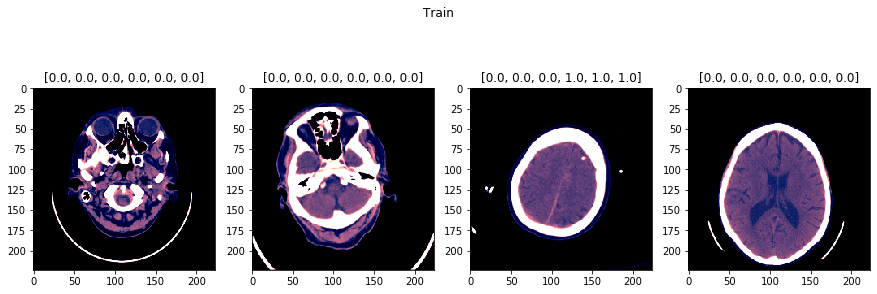

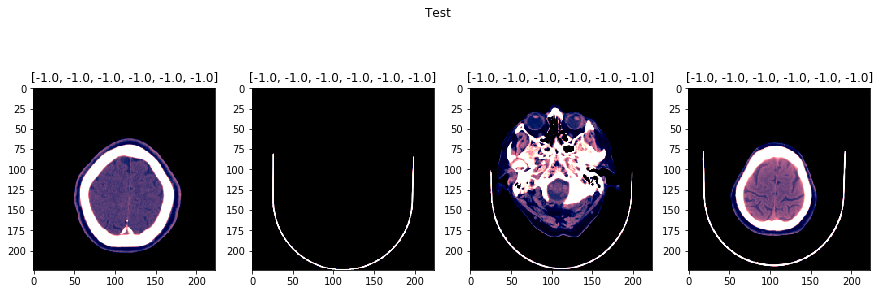

In [10]:
x, y = next(iter(train_dataloader))
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
plt.suptitle("Train")
for i in range(4):
    axs[i].set(title=str(y[i].tolist()))
    axs[i].imshow(np.transpose(x[i].numpy(), (1,2,0)), cmap=plt.cm.bone )

x, y = next(iter(test_dataloader))
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
plt.suptitle("Test")
for i in range(4):
    axs[i].set(title=str(y[i].tolist()))
    axs[i].imshow(np.transpose(x[i].numpy(), (1,2,0)), cmap=plt.cm.bone )

## Model & Optimizer

In [11]:
model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, n_classes)

if torch.cuda.is_available():
    model = model.cuda()
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model, optimizer = amp.initialize(model, optimizer, opt_level="O1")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


## Helper Utilities

In [12]:
class AverageMeter(object):
    """Compute and store the average, standard deviation, and current value"""

    def __init__(self, name="Meter", fmt=":f"):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.sqsum = 0
        self.count = 0
        self.std = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.sqsum += (val ** 2) * n
        self.count += n
        self.avg = self.sum / self.count
        self.std = ((self.sqsum / self.count) - (self.avg * self.avg)) ** 0.5

    def __str__(self):
        fmtstr = "{name} {val" + self.fmt + "} (AVG {avg" + self.fmt + "}, STD {std" + self.fmt + "})"
        return fmtstr.format(**self.__dict__)

In [13]:
writer = SummaryWriter()
print(writer.log_dir)

runs/Nov27_12-18-20_patience


## Train

In [14]:
def train(epoch=-1):
    model.train()
    loss_meter = AverageMeter()
    datatime_meter = AverageMeter()
    batchtime_meter = AverageMeter()
    with tqdm(train_dataloader, total=len(train_dataloader), desc="Epoch {}".format(epoch)) as t:
        end = time()
        for step, (inputs, targets) in enumerate(t):
            b_start = time()

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()
            predictions = model(inputs)
            loss = criterion(predictions, targets)

            optimizer.zero_grad()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()

            loss_meter.update(loss.item())
            datatime_meter.update(b_start - end)
            end = time()
            batchtime_meter.update(end - b_start)
            t.set_postfix_str(
                "Loss: {loss:.3f} (loss_avg:.3f) | Data: {dtime:.2f}s ({dtime_avg:.2f}s) | Batch: {btime:.2f}s ({btime_avg:.2f}s)".format(
                    loss=loss_meter.val,
                    loss_avg=loss_meter.avg,
                    dtime=datatime_meter.val,
                    dtime_avg=datatime_meter.avg,
                    btime=batchtime_meter.val,
                    btime_avg=batchtime_meter.avg,                    
            ))
            writer.add_scalar("Loss/Train", loss.item(), step + max(0, epoch) * len(train_dataloader))

In [ ]:
for epoch in range(n_epochs):
    train(epoch)

## Inference


In [ ]:
def inference():
    model.eval()
    test_pred = np.zeros((len(test_dataset) * n_classes, 1))

    with tqdm(test_dataloader, desc="Infer") as t:
        end = time()
        for step, (inputs, _) in enumerate(t):
            b_start = time()
            if torch.cuda.is_available():
                inputs = inputs.cuda()
            predictions = model(inputs)
            bs = predictions.size(0)
            test_pred[(step*bs*n_classes): ((step+1)*bs*n_classes)] = torch.sigmoid(
                predictions
            ).detach().cpu().reshape((bs*n_classes, 1))
    return test_pred

test_predictions = inference()

## Submission

In [ ]:
submission = pd.read_csv(base_test_csv)
assert len(submission) == len(test_predictions)
submission = submission.drop(columns=["Label"])
submission["Label"] = pd.DataFrame(test_predictions)

submission.to_csv("submission.csv", index=False)
# !kaggle competitions submit -c rsna-intracranial-hemorrhage-detection -f submission.csv -m "Submission"
submission.head()

